<a href="https://colab.research.google.com/github/svakeczw/Neural-Style-Transfer/blob/main/NeuralStyleTransfer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import cv2
import IPython.display as display
import PIL.Image
import IPython.display as display

In [2]:
content_path = '/content/content_2.jpg'
style_path = '/content/my_style.jpg'

In [3]:
def view_img(img_path, img_title):
  img = cv2.imread(img_path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = img / 255
  plt.figure(figsize=(8,8))
  plt.title(img_title)
  plt.imshow(img)
  plt.show()

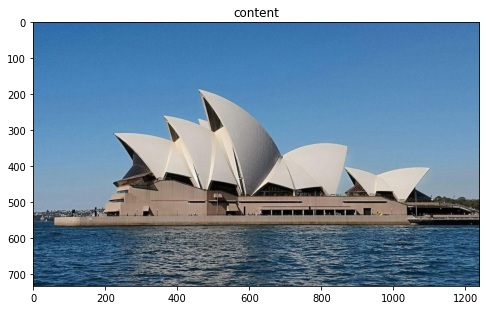

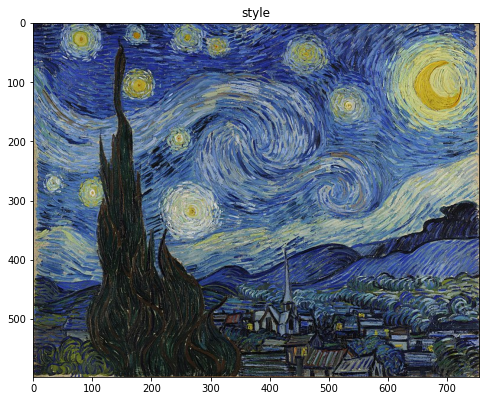

In [5]:
# view content image
view_img(content_path, img_title='content')
# view style image
view_img(style_path, img_title='style')

In [7]:
# view the vgg layers
# vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
# for layer in vgg.layers:
  # print(layer.name)
content_layers = ['block4_conv2']  # define content layers
style_layers = [
                'block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1'
]  # define style layers

In [8]:
# build customized vgg model
def vgg_layers(layer_names):
  vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
  vgg.trainable = False
  outputs = [vgg.get_layer(name).output for name in layer_names]
  model = tf.keras.Model(inputs=vgg.input, outputs=outputs)
  return model

In [9]:
# calculate gram matrix
def gram_matrix(input_tensor):
  ans = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
  input_shape = tf.shape(input_tensor)[1:]
  num_elements = tf.cast(input_shape[0] * input_shape[1], tf.float32)
  ans = ans / num_elements
  return ans

In [10]:
# Style transfer model
class StyleTransferModel(tf.keras.Model):
  def __init__(self, style_layers, content_layers):
    super(StyleTransferModel, self).__init__()
    self.style_layers = style_layers
    self.content_layers = content_layers
    self.n = len(style_layers)  # num of style layers
    self.vgg = vgg_layers(style_layers + content_layers)
    self.vgg.trainable = False

  def call(self, inputs):
    inputs = inputs * 255
    inputs = tf.keras.applications.vgg19.preprocess_input(inputs)


    outputs = self.vgg(inputs)
    style_outputs, content_outputs = outputs[:self.n], outputs[self.n:]

    style_outputs = [gram_matrix(output_style) for output_style in style_outputs]
    
    content_dic = {k:v for k,v in zip(self.content_layers, content_outputs)}

    style_dic = {k:v for k,v in zip(self.style_layers, style_outputs)}

    return {'content': content_dic,
            'style': style_dic}

In [11]:
# preprocess image
def load_img(img_path, max_size):
  img = tf.io.read_file(img_path)
  img = tf.io.decode_image(img)
  img = tf.image.convert_image_dtype(img, tf.float32)  # img / 255.0
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  if long_dim > max_size:
    scale = max_size / long_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    img = tf.image.resize(img, new_shape)
  img = tf.expand_dims(img, axis=0)  # add batch dim
  return img

In [12]:
# clip the pixel value between 0 and 1
def clip_img(image):
  return tf.clip_by_value(image,0,1)

In [13]:
stf_model = StyleTransferModel(style_layers, content_layers)

style_image = load_img(style_path, 512)
content_image = load_img(content_path, 512)


style_target = stf_model(style_image)['style']  # get target style
content_target = stf_model(content_image)['content']  # get target content

generated_image = tf.Variable(content_image)  # initialize generated image as content image

80142336/80134624 [==============================] - 0s 0us/step


In [14]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.02)

# weights for content cost and style cost
content_cost_alpha = 1
style_cost_beta = 100

# weights for each layer
style_layer_weights = [
                       tf.constant(0.2, tf.float32),  # block1_conv1
                       tf.constant(0.2, tf.float32),  # block2_conv1
                       tf.constant(0.2, tf.float32),  # block3_conv1
                       tf.constant(0.2, tf.float32),  # block4_conv1
                       tf.constant(0.2, tf.float32),  # block5_conv1
]

In [15]:
# content style loss
def content_style_loss(outputs):
  style_outputs = outputs['style']
  content_outputs = outputs['content']


  # mean square error loss
  style_loss = [tf.reduce_mean((style_outputs[name] - style_target[name])**2) for name in style_outputs.keys()]
  style_loss = [style_loss[i] * style_layer_weights[i] for i in range(len(style_outputs))] 


  style_loss = tf.reduce_sum(style_loss)
  style_loss *= style_cost_beta

  content_loss = [tf.reduce_mean((content_outputs[name] - content_target[name])**2) for name in content_outputs.keys()]
  content_loss = tf.reduce_sum(content_loss)
  content_loss *= content_cost_alpha

  loss = content_loss + style_loss

  return loss

In [21]:
# define one training step
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = stf_model(image)
    loss = content_style_loss(outputs)
  gradients = tape.gradient(loss, image)
  optimizer.apply_gradients([(gradients, image)])
  image.assign(clip_img(image))

In [17]:
# display the image
def show_tensor_img(img_tensor):
  img = img_tensor * 255
  img = np.asarray(img, dtype='uint8')
  img = np.squeeze(img)
  return PIL.Image.fromarray(img)

Generated image after trained for 1 epoch


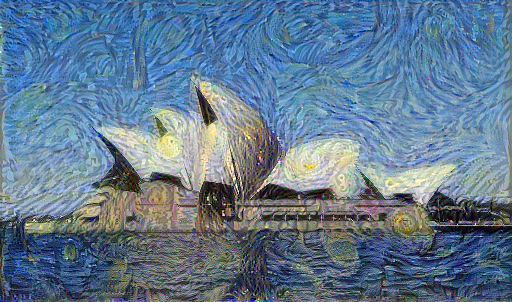

epoch: 1 done !
Generated image after trained for 2 epoch


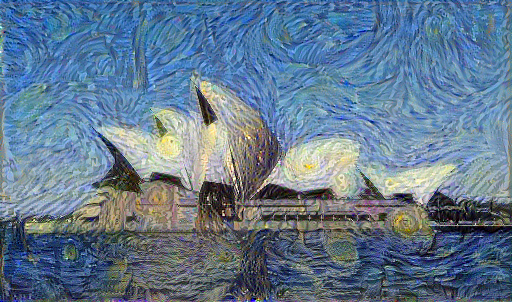

epoch: 2 done !
Generated image after trained for 3 epoch


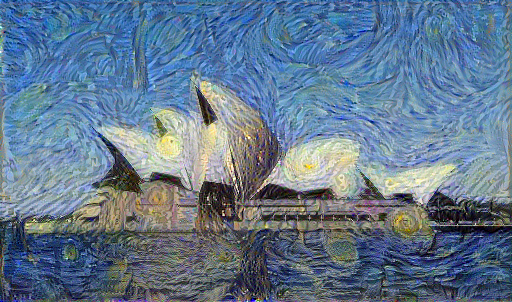

epoch: 3 done !


In [22]:
# training
epoch = 3
step_each_epoch = 100

for i in range(epoch):
  for _ in range(step_each_epoch):
    train_step(generated_image)
    if _ == 99:
      # display.clear_output(wait=True)
      print(f'Generated image after trained for {i+1} epoch')
      display.display(show_tensor_img(generated_image))
  print(f'epoch: {i+1} done !')